In [23]:
REPO_NAME = 'Random-Forest-forecasting' #@param {type:"string"}
from google.colab import drive
drive.mount('/content/gdrive')

%run /content/gdrive/My\ Drive/lib/InitLib.ipynb


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Vesion:1.2
mkdir: cannot create directory ‘/content/gdrive/My Drive/src/’: File exists
Cloning into 'Random-Forest-forecasting'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 289 (delta 14), reused 24 (delta 1), pack-reused 252
Receiving objects: 100% (289/289), 81.98 MiB | 16.44 MiB/s, done.
Resolving deltas: 100% (117/117), done.
Checking out files: 100% (46/46), done.


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import r2_score
%matplotlib inline
 
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

In [0]:
sales_data = pd.read_csv(REPO_DIR + '/Autoregression/retail_sales.csv')
sales_data['date']=pd.to_datetime(sales_data['date'])
sales_data.set_index('date', inplace=True)

In [27]:
sales_data.head()

,sales
date,
2009-10-01,338630
2009-11-01,339386
2009-12-01,400264
2010-01-01,314640
2010-02-01,311022


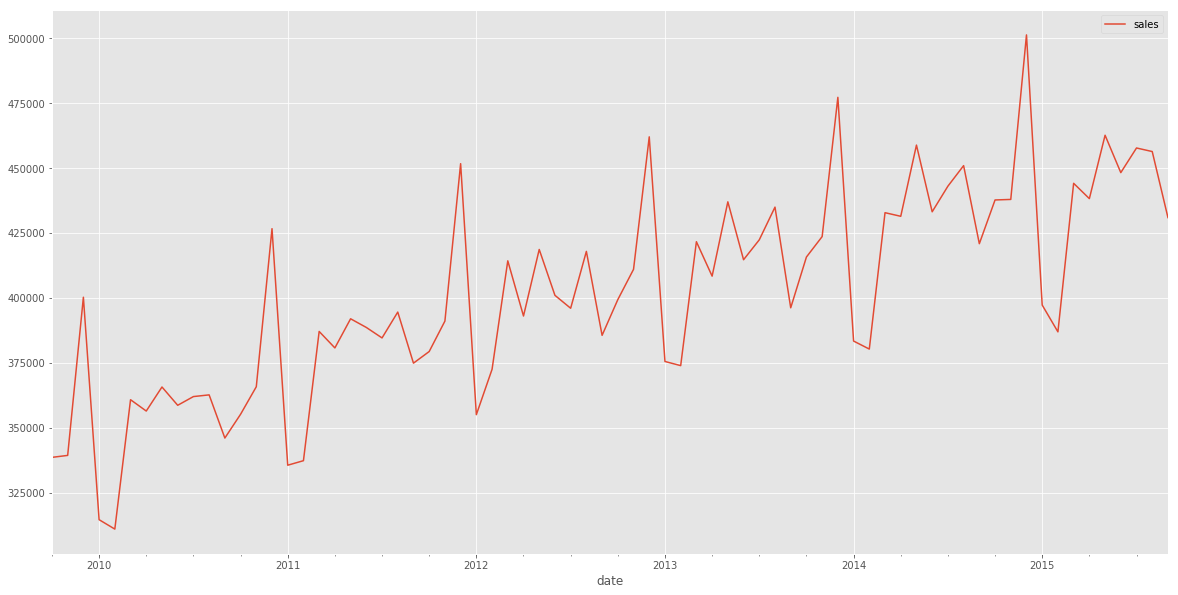

In [28]:
sales_data.plot()

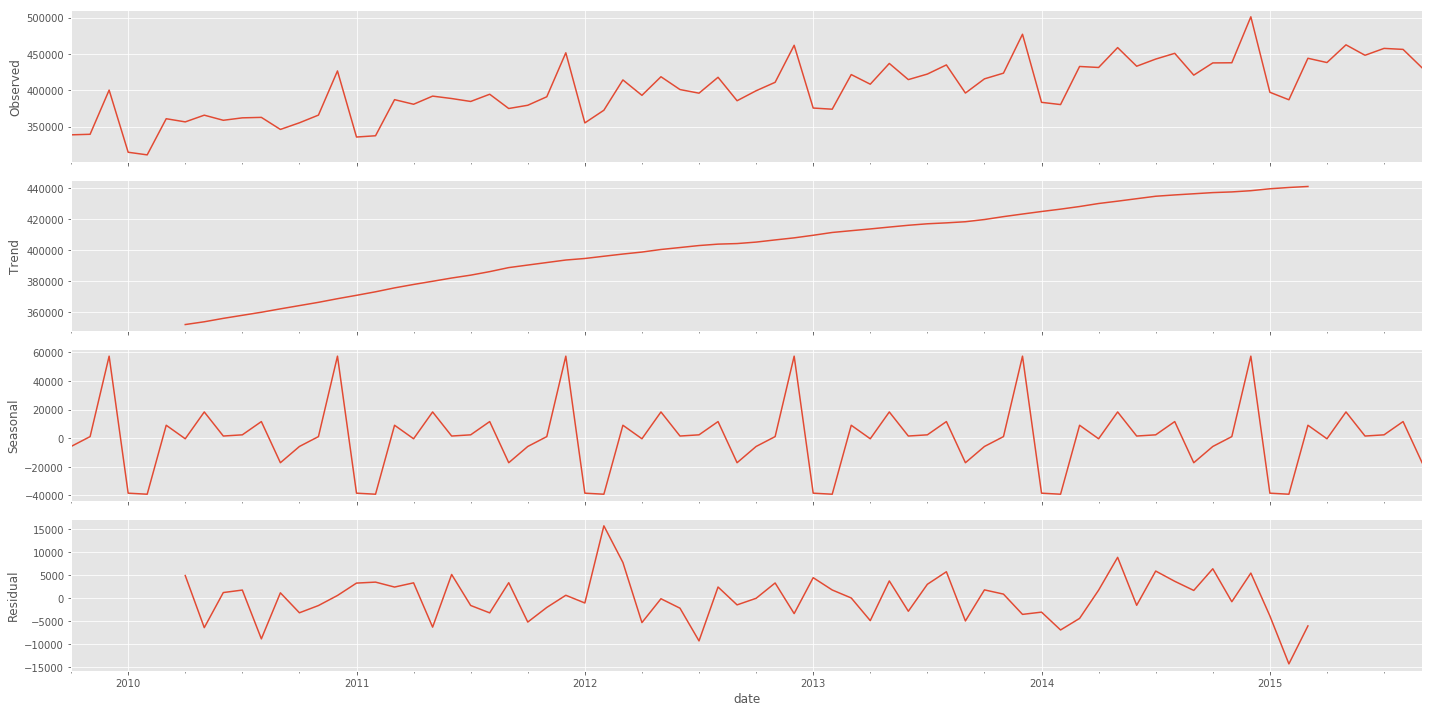

In [29]:
decomposed = seasonal_decompose(sales_data['sales'], model='additive')
x =decomposed.plot() #See note below about this

In [0]:
sales_data['stationary']=sales_data['sales'].diff()


In [31]:
sales_data.head()

,sales,stationary
date,,
2009-10-01,338630,NaN
2009-11-01,339386,756.0
2009-12-01,400264,60878.0
2010-01-01,314640,-85624.0
2010-02-01,311022,-3618.0


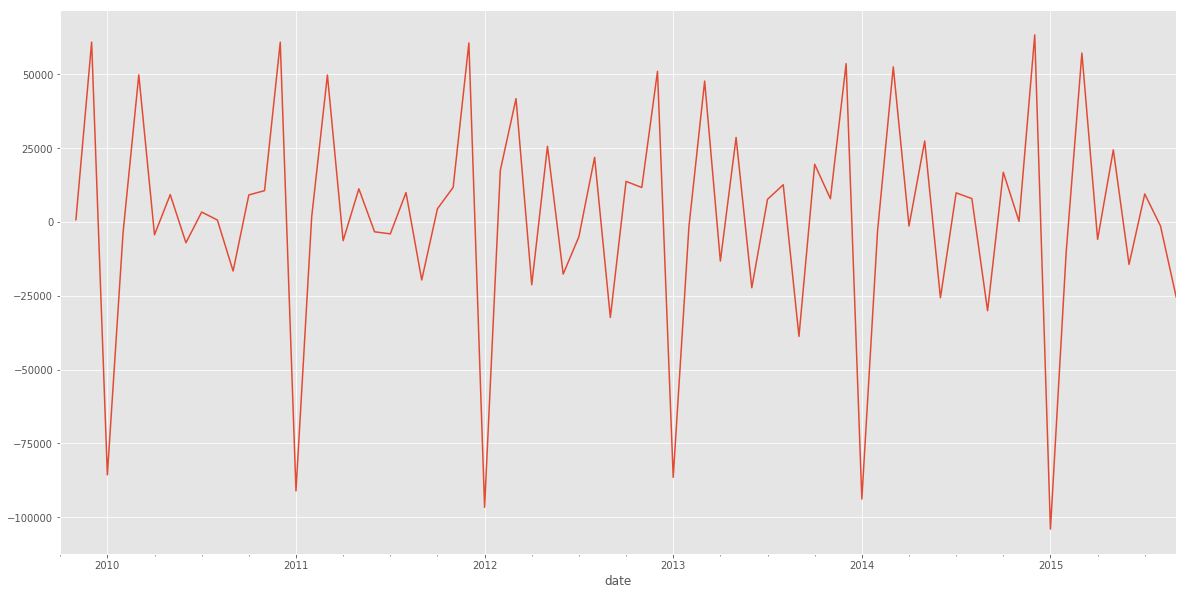

In [32]:
sales_data['stationary'].plot()

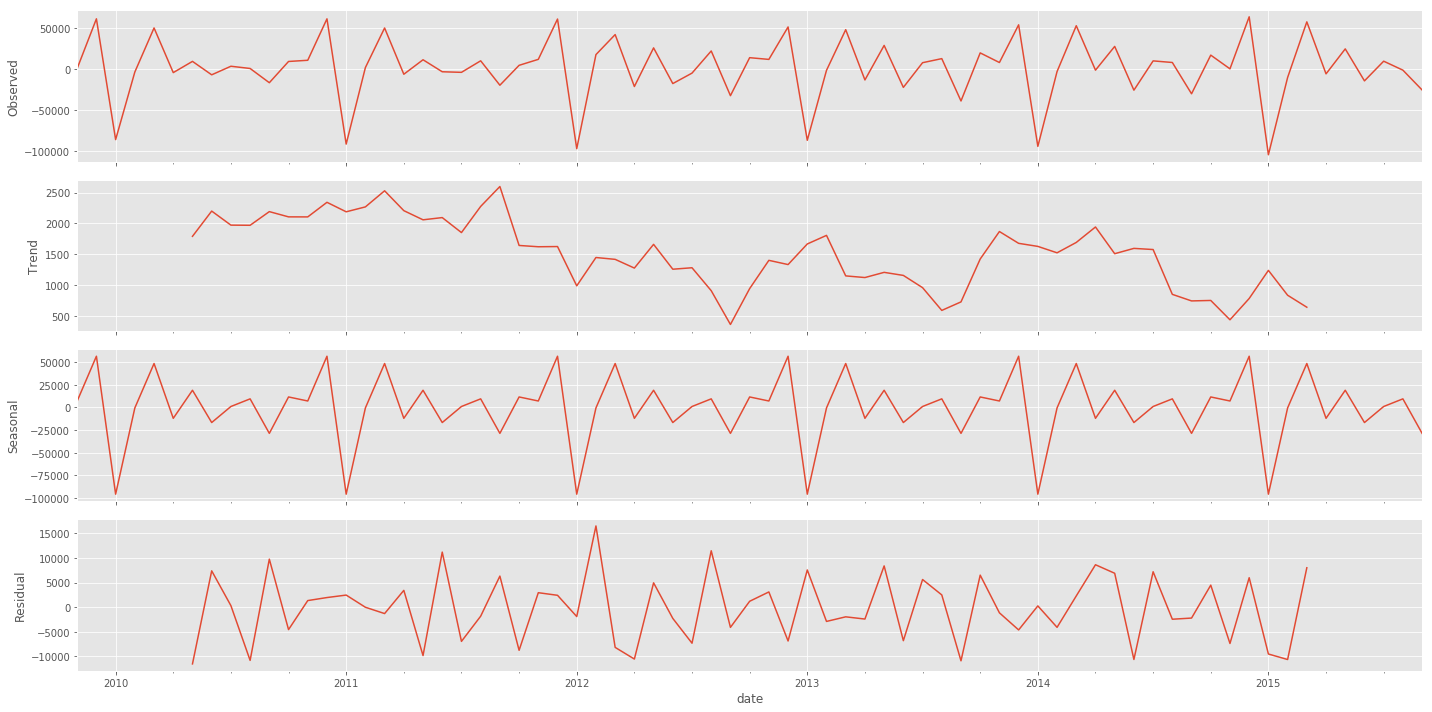

In [33]:
decomposed = seasonal_decompose(sales_data['stationary'].dropna(), model='additive')
x =decomposed.plot() #See note below about this

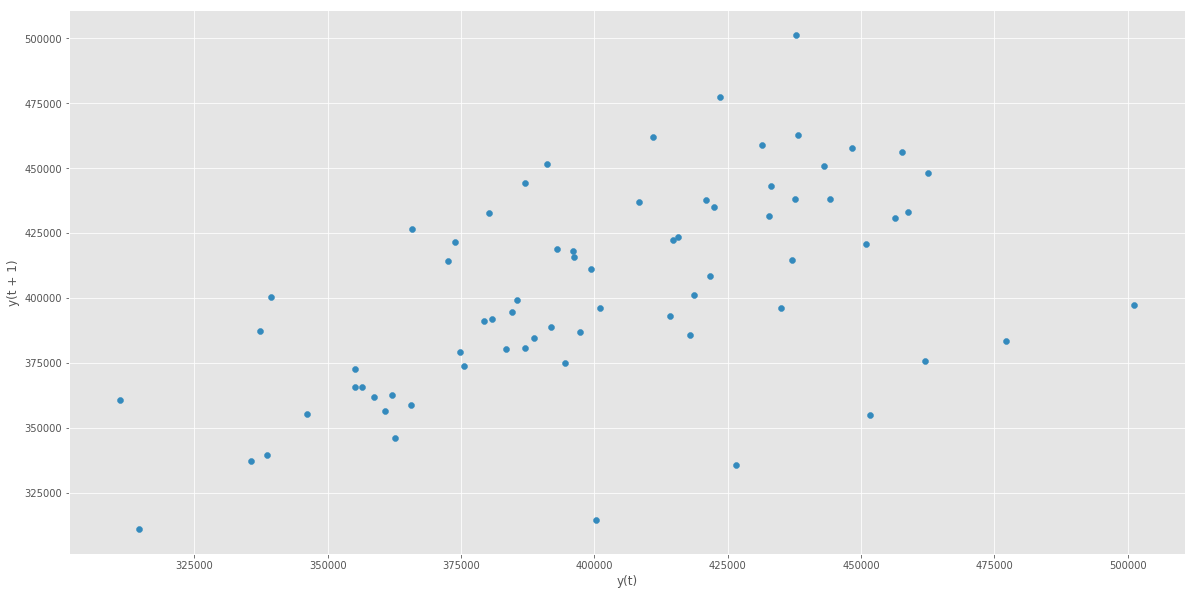

In [35]:
pd.plotting.lag_plot(sales_data['sales'])

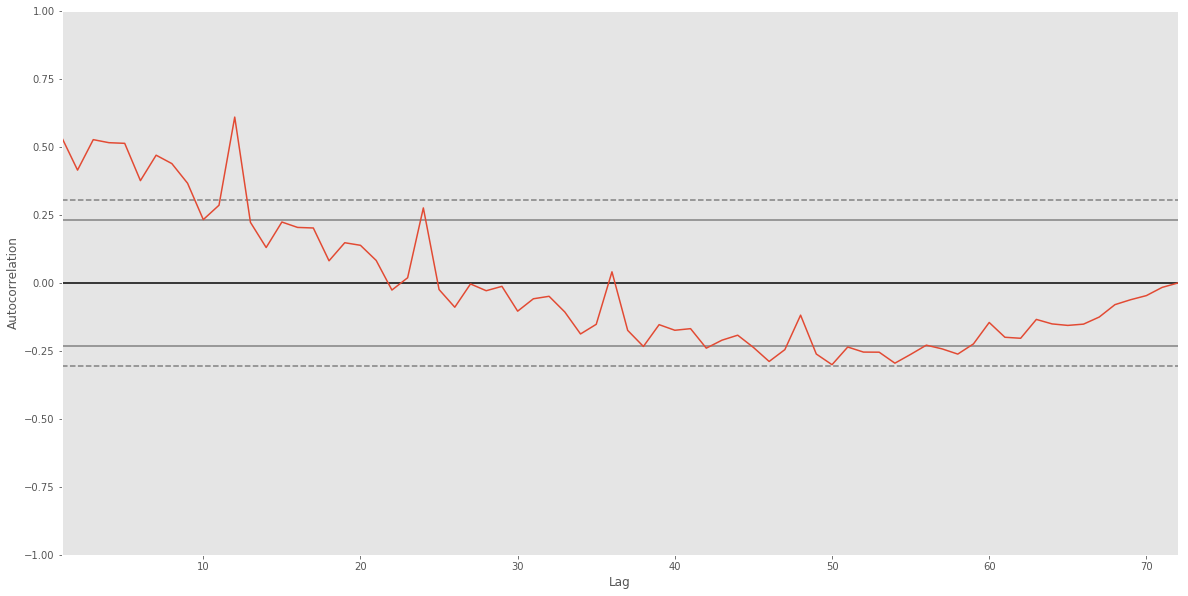

In [36]:
pd.plotting.autocorrelation_plot(sales_data['sales'])

In [37]:
sales_data['sales'].corr(sales_data['sales'].shift(12))

0.9790985975895788

In [0]:
#create train/test datasets
X = sales_data['stationary'].dropna()

train_data = X[1:len(X)-12]
test_data = X[X[len(X)-12:]]


In [39]:
#train the autoregression model
model = AR(train_data)
model_fitted = model.fit()


/usr/local/lib/python2.7/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python2.7/dist-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


In [40]:
print('The lag value chose is: %s' % model_fitted.k_ar)


The lag value chose is: 10


In [41]:
print('The coefficients of the model are:\n %s' % model_fitted.params)

The coefficients of the model are:
 const             7720.952626
L1.stationary       -1.297636
L2.stationary       -1.574980
L3.stationary       -1.403045
L4.stationary       -1.123204
L5.stationary       -0.472200
L6.stationary       -0.014586
L7.stationary        0.564099
L8.stationary        0.792080
L9.stationary        0.843242
L10.stationary       0.395546
dtype: float64


In [42]:
# make predictions 
predictions = model_fitted.predict(
    start=len(train_data), 
    end=len(train_data) + len(test_data)-1, 
    dynamic=False)

# create a comparison dataframe
compare_df = pd.concat(
    [sales_data['stationary'].tail(12),
    predictions], axis=1).rename(
    columns={'stationary': 'actual', 0:'predicted'})

/usr/local/lib/python2.7/dist-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


In [43]:
compare_df

,actual,predicted
2014-10-01,16831.0,5601.811846
2014-11-01,208.0,38414.120561
2014-12-01,63322.0,35441.708285
2015-01-01,-103980.0,-49947.389001
2015-02-01,-10317.0,-21617.841678
2015-03-01,57175.0,20818.987209
2015-04-01,-5893.0,14274.367772
2015-05-01,24398.0,15474.495929
2015-06-01,-14386.0,-12799.912704
2015-07-01,9481.0,10743.906740


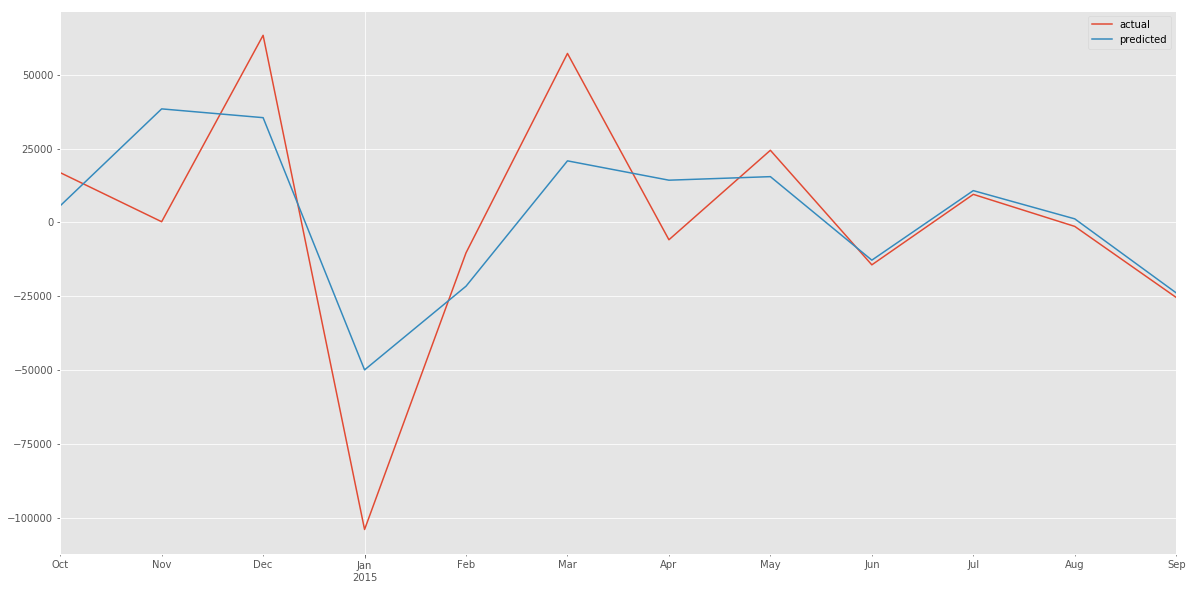

In [44]:
compare_df.plot()

In [0]:
r2 = r2_score(sales_data['stationary'].tail(12), predictions)

In [46]:
r2

0.6392721768478096